In [3]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [4]:
REBUILD_DATA = False

In [5]:
class DogsVSCats():
  IMG_SIZE = 50
  CATS = "data/cats_dogs/train/cat"
  DOGS = "data/cats_dogs/train/dog"
  LABELS = {CATS:0,DOGS:1}
  
  training_data = []
  catcount = 0
  dogcount = 0
  
  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label,f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
          
          if label == self.CATS:
            self.catcount += 1
          elif label == self.DOGS:
            self.dogcount += 1
        except Exception as e:
          pass
          #print(str(e))
          
    np.random.shuffle(self.training_data)
    np.save("data/cats_dogs/train/training_data.npy", self.training_data)
    print("Cats: ", self.catcount)
    print("Dogs: ", self.dogcount)
    
if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()


In [6]:
training_data = np.load("data/cats_dogs/train/training_data.npy", allow_pickle=True)

In [7]:
print(len(training_data))

25000


In [8]:
print(training_data[0])

[array([[205, 129, 139, ..., 217, 217, 200],
       [211, 187, 193, ..., 220, 219, 204],
       [213, 214, 212, ..., 223, 222, 207],
       ...,
       [171, 141, 119, ..., 163, 161, 160],
       [101, 126, 166, ..., 161, 162, 163],
       [184, 187, 187, ...,  91, 151, 162]], dtype=uint8)
 array([1., 0.])]


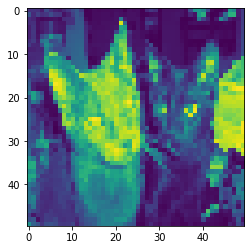

[1. 0.]


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(training_data[1][0])
plt.show()
print(training_data[1][1])

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)
    x = torch.randn(50,50).view(-1,1,50,50)
    self._to_linear = None
    self.convs(x)
    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)
  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)

net = Net()

In [18]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2500


In [19]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22500
2500


In [20]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
  print("epoch: " + str(epoch))
  for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
    batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
    batch_y = train_y[i:i+BATCH_SIZE]
    
    net.zero_grad()
    outputs = net(batch_X)
    loss = loss_function(outputs, batch_y)
    loss.backward()
    optimizer.step()
    
print(loss)

100%|██████████| 225/225 [00:44<00:00,  5.02it/s]


epoch: 0
tensor(0.2615, grad_fn=<MseLossBackward>)


In [21]:
correct = 0
total = 0
with torch.no_grad():
  for i in tqdm(range(len(test_X))):
    real_class = torch.argmax(test_y[i])
    net_out = net(test_X[i].view(-1,1,50,50))[0]
    predicted_class = torch.argmax(net_out)
    if predicted_class == real_class:
      correct += 1
    total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2500/2500 [00:03<00:00, 733.33it/s]


Accuracy:  0.65


In [22]:
torch.cuda.is_available()

True

In [23]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [24]:
torch.cuda.device_count()

1

In [25]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [34]:
BATCH_SIZE = 100
EPOCHS = 10
def train(net):
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  loss_function = nn.MSELoss()
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
      batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
      batch_y = train_y[i:i+BATCH_SIZE]
      
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)
      
      net.zero_grad()
      outputs = net(batch_X)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step()
    print("epoch: " + str(epoch) + "\tloss: " + str(loss))
    
train(net)

100%|██████████| 225/225 [00:05<00:00, 43.54it/s]


epoch: 0	loss: tensor(0.1944, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 1	loss: tensor(0.1857, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 2	loss: tensor(0.1718, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 3	loss: tensor(0.1610, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 4	loss: tensor(0.1694, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 5	loss: tensor(0.1659, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 6	loss: tensor(0.1506, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 7	loss: tensor(0.1377, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 8	loss: tensor(0.1273, device='cuda:0', grad_fn=<MseLossBackward>)
epoch: 9	loss: tensor(0.1697, device='cuda:0', grad_fn=<MseLossBackward>)


In [35]:
def test(net):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X))):
      real_class = torch.argmax(test_y[i]).to(device)
      net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]
      predicted_class = torch.argmax(net_out)

      if predicted_class == real_class:
        correct += 1
      total += 1
      
  print("Accuracy: ", round(correct/total, 3))
  
test(net)

100%|██████████| 2500/2500 [00:02<00:00, 848.29it/s]


Accuracy:  0.738
